In [ ]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from gdsfactory.read import from_np

from gdsfactory.boolean import boolean
from gdsfactory.component import Component

In [2]:
def compute_area_signed(pr) -> float:
    """Return the signed area enclosed by a ring using the linear time.

    algorithm at http://www.cgafaq.info/wiki/Polygon_Area. A value >= 0
    indicates a counter-clockwise oriented ring.

    """
    xs, ys = map(list, zip(*pr))
    xs.append(xs[1])
    ys.append(ys[1])
    return sum(xs[i] * (ys[i + 1] - ys[i - 1]) for i in range(1, len(pr))) / 2.0  # type: ignore[no-any-return]

In [ ]:
def my_from_np(
    ndarray,
    nm_per_pixel: int = 20,
    layer: tuple[int, int] = (1, 0),
    threshold: float = 0.99,
    invert: bool = True,
):
    """Returns Component from a np.ndarray.

    Extracts contours skimage.measure.find_contours using `threshold`.

    Args:
        ndarray: 2D ndarray representing the device layout.
        nm_per_pixel: scale_factor.
        layer: layer tuple to output gds.
        threshold: value along which to find contours in the array.
        invert: invert the mask.
    """
    from skimage import measure

    c = Component()
    ndarray = np.pad(ndarray, 2)
    contours = measure.find_contours(ndarray, threshold)  # type: ignore[no-untyped-call]
    assert len(contours) > 0, (
        f"no contours found for threshold = {threshold}, maybe you can reduce the"
        " threshold"
    )
  
    polygons = []
    for contour in contours:
        area = -compute_area_signed(contour)

        c = Component()
        points = contour * 1e-3 * nm_per_pixel
        c.add_polygon(points, layer=layer)
        polygons.append((area, c))
    
    if len(polygons) == 1:
        return polygons[0][1]
    polygons = sorted(polygons, key=lambda x: abs(x[0]), reverse=True)

    cur_poly = polygons[0][1] # this is the largest one, must be positive area

    for area, poly in polygons[1:]:
        if area > 0:
            cur_poly = boolean(cur_poly, poly, operation="or", layer=layer)
        else:
            cur_poly = boolean(cur_poly, poly, operation="-", layer=layer)
   
    return cur_poly

84
Area: -0.5
Area: -20.5
Area: -309.5
Area: -58.5
Area: -8.5
Area: -620.5
Area: -2463.5
Area: -6.5
Area: -104.5
Area: -28.5
Area: -26.5
Area: -48.5
Area: 22.5
Area: -35.5
Area: -28.5
Area: -12.5
Area: -2.5
Area: -18.5
Area: -16.5
Area: 21.5
Area: -10.5
Area: -13.5
Area: 4.5
Area: -17.5
Area: -13.5
Area: -18.5
Area: -687.5
Area: 11.5
Area: 135.5
Area: 9.5
Area: -0.5
Area: -0.5
Area: -3.5
Area: -14.5
Area: 5.5
Area: 2.5
Area: 6.5
Area: 6.5
Area: 6.5
Area: -30.5
Area: -132.5
Area: -41.5
Area: -11.5
Area: 6.5
Area: -28.5
Area: -0.5
Area: 158.5
Area: -26.5
Area: -2.5
Area: -8.5
Area: -30.5
Area: 24.5
Area: -66.5
Area: -22.5
Area: -2.5
Area: -7.5
Area: -0.5
Area: -15.5
Area: -35.5
Area: -6.5
Area: 5.5
Area: -5.5
Area: -39.5
Area: -22.5
Area: -20.5
Area: -12.5
Area: 1.5
Area: -13.5
Area: -0.5
Area: -12.5
Area: -3.5
Area: -16.5
Area: -16.5
Area: -1.5
Area: -3.5
Area: 14.5
Area: -20.5
Area: -0.5
Area: -19.5
Area: 7.5
Area: 3.5
Area: 13.5
Area: -4.5
Area: -2.5
Component(name=Unnamed_6928, ports

PosixPath('contour.gds')

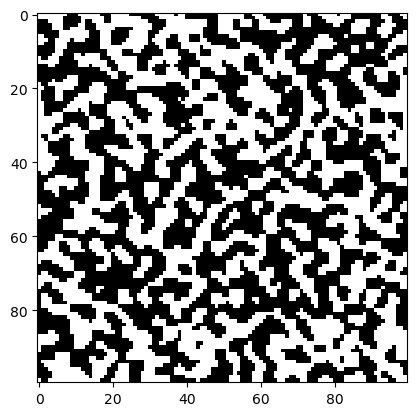

In [49]:
a = np.zeros((100, 100), dtype=np.float32)
a[10:90, 10:90] = 1
a[20:80, 20:80] = 0
a[30:70, 30:70] = 0

a = np.random.randint(0, 2, size=(100, 100))
## remove high frequency compoent, low pass filter through fft
f = np.fft.fft2(a)
fshift = np.fft.fftshift(f)
rows, cols = a.shape
crow, ccol = rows // 2, cols // 2
# remove high frequency components, center compoent are low frequency
fshift[crow + 20:] = 0
fshift[:crow - 20] = 0
fshift[:, ccol + 20:] = 0
fshift[:, :ccol - 20] = 0

f_ishift = np.fft.ifftshift(fshift)
a = np.round(np.fft.ifft2(f_ishift).real)

fig, ax = plt.subplots()

ndarray = np.pad(a, 2)
ax.imshow(np.flipud(a.T), cmap=plt.cm.gray)
contours = measure.find_contours(ndarray, 0.5)  # type: ignore[no-untyped-call]
print(len(contours))
for contour in contours:
    area = compute_area_signed(contour)
    print(f'Area: {area}')
    # print(contour)

c = my_from_np(a,threshold = 0.5, nm_per_pixel=10, invert=False)
print(c)
c.write_gds("contour.gds")
    